# Volumetrics

We'll implement the volumetric equation to compute hydrocarbons in place (HCIP):

$$ \mathrm{HCIP} = A \times T \times G \times \phi \times N\!\!:\!\!G \times S_\mathrm{O} \times \frac{1}{B_\mathrm{O}} $$

On the way, we'll see the following important patterns:

- Using functions to represent equations and chunks of computation.
- The library `pint` for dealing with physical units and currencies.
- Using a web API to retrieve live oil prices from the Internet.
- The generation of random variables for stochastic simulation.
- The mapping of a function to a large dataset to do a lot of work at once.
----


## Gross rock volume 

$$ \mathrm{GRV} = A \times T $$

In [1]:
thick = 80            # metres
area = 20000 * 30000  # metres

grv = thick * area
grv

48000000000

Wouldn't it be cool if we could carry units around with our calculations? With [`pint`](https://pint.readthedocs.io/en/latest/index.html), we can!

In [2]:
!pip install pint

In [3]:
import pint

unit = pint.UnitRegistry()

thick = 80 * unit.m
area = 20000 * unit.m * 30000 * unit.m
grv = thick * area
grv

<Quantity(48000000000.0, 'meter ** 3')>

In [4]:
def calculate_grv(thickness, area):
    return thickness * area

Now we can just call this function, instead of remembering the equation. (Admittedly, the equation is rather easy to remember in this case!)

In [5]:
calculate_grv(thick, area)

<Quantity(48000000000.0, 'meter ** 3')>

It works!

Now we need to compensate for the prospect not being a flat slab of rock &mdash; using the geometric factor. 

We will implement the equations implied by this diagram:

<html><img src="http://subsurfwiki.org/images/6/66/Geometric_correction_factor.png", width=600></html>

In [7]:
def geometric_factor(thick, height, top='slab'):

    ratio = thick / height

    if top == 'round':
        g = -0.6 * ratio + 1
    elif top == 'flat':
        g = -0.3 * ratio + 1
    else:
        g = 1

    return g

In [8]:
geometric_factor(thick, height=100*unit.m, top='round')

<Quantity(0.52, 'dimensionless')>

In [9]:
grv *= g

NameError: name 'g' is not defined

## HC pore volume

We need:

- net:gross &mdash; the ratio of reservoir-quality rock thickness to the total thickness of the interval.
- porosity
- $S_\mathrm{O}$ &mdash; the oil saturation, or proportion of oil to total pore fluid.

In [10]:
# These are all dimensionless
netg = 0.5
por = 0.24
s_o = 0.8

hcpv = netg * por * s_o

In [11]:
def calculate_hcpv(netg, por, s_o):
    """A function to compute the hydrocarbon pore volume."""
    hcpv = netg * por * s_o
    return hcpv

## Hydrocarbons in place

Oil shrinks when we produce it, especially if it has high GOR. The FVF, or $B_O$, is the ratio of a reservoir barrel to a stock-tank barrel (25 deg C and 1 atm). Typically the FVF is between 1 (heavy oil) and 1.7 (high GOR).

In [17]:
fvf = 1.1

In [18]:
hcip = grv * hcpv / fvf
hcip

<Quantity(4189090909.0909085, 'meter ** 3')>

In [19]:
print("HCIP is {:.0f} million {}".format(hcip.magnitude/1000000, hcip.units))

HCIP is 4189 million meter ** 3


In [20]:
hcip.to('imperial_barrel')

<Quantity(25596421620.257484, 'imperial_barrel')>

An Imperial barrel is 43 gallons ([Wikipedia](https://en.wikipedia.org/wiki/Barrel_(unit))), whereas an oil barrel is only 42 gallons. So let's define a custom unit:

In [21]:
unit.define('oil_barrel = 42 gallon = bbl')

In [22]:
hcip.to('bbl')

<Quantity(26348589118.31922, 'oil_barrel')>

[For more on conversion to bbl, BOE, etc.](https://en.wikipedia.org/wiki/Barrel_of_oil_equivalent)

## What's this worth?

In [23]:
!pip install requests

In [24]:
import requests

url = 'https://www.quandl.com/api/v3/datasets/CHRIS/ICE_B1/data.json'
params = dict(start_date='2018-10-01',
              column_index='open',
              exclude_column_names='true',
             )

re = requests.get(url, params)

data = re.json()

In [25]:
data

{'dataset_data': {'limit': None,
  'transform': None,
  'column_index': 1,
  'column_names': ['Date', 'Open'],
  'start_date': '2018-10-01',
  'end_date': '2018-10-24',
  'frequency': 'daily',
  'data': [['2018-10-24', 76.35],
   ['2018-10-23', 80.04],
   ['2018-10-22', 80.11],
   ['2018-10-19', 79.44],
   ['2018-10-18', 80.23],
   ['2018-10-17', 81.74],
   ['2018-10-16', 80.88],
   ['2018-10-15', 81.0],
   ['2018-10-12', 80.28],
   ['2018-10-11', 82.47],
   ['2018-10-10', 84.98],
   ['2018-10-09', 83.91],
   ['2018-10-08', 84.17],
   ['2018-10-05', 84.89],
   ['2018-10-04', 85.99],
   ['2018-10-03', 84.79],
   ['2018-10-02', 84.95],
   ['2018-10-01', 82.79]],
  'collapse': None,
  'order': None}}

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt

In [27]:
import pandas as pd

df = pd.DataFrame(data['dataset_data']['data'], columns=['Date', 'Price'])

In [28]:
df.head()

,Date,Price
0,2018-10-24,76.35
1,2018-10-23,80.04
2,2018-10-22,80.11
3,2018-10-19,79.44
4,2018-10-18,80.23


In [29]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

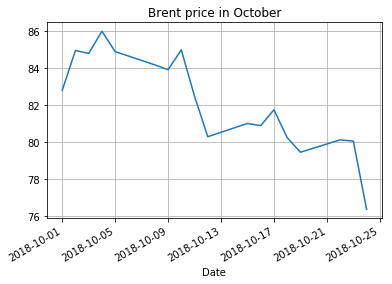

In [30]:
df.Price.plot()
plt.title("Brent price in October")
plt.grid()
plt.show()

In [31]:
unit.define('usd = [currency]')

In [33]:
value = hcip.to('bbl') * df.Price.mean() * unit.usd / unit.bbl

In [34]:
f"Hypothetical value: {value:0.2e}"

'Hypothetical value: 2.16e+12 usd'

## Monte Carlo simulation

So far, everything we've done has been deterministic. That is, given a set of parameters, we'll always get the same answer. But often, we'd like to deal with uncertainty. One way to do this is with stochastic simulation --- drawing random variables from a distribution.

We can draw randomly from distributions of properties:

- Normal: https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.normal.html
- Uniform: https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.uniform.html
- Lognormal: https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.lognormal.html

In [35]:
def calculate_hcip(thick, area, height, top, netg, por, s_o, fvf):
    grv = calculate_grv(thick, area)
    grv *= geometric_factor(thick, height, top)
    hcpv = calculate_hcpv(netg, por, s_o)
    return grv * hcpv / fvf

In [36]:
import numpy as np

trials = 100

area = np.random.normal(loc=2e4*3e4, scale=1e4, size=trials) * unit.m * unit.m
por = np.random.normal(loc=0.15, scale=0.025, size=trials)

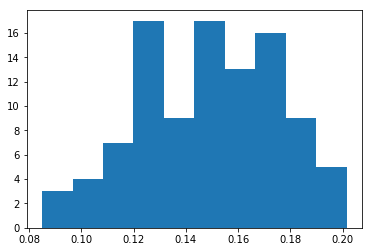

In [37]:
_ = plt.hist(por)

In [40]:
height = 100
hcip = calculate_hcip(thick, area, height, top, netg, por, s_o, fvf)

In [41]:
hcip

<Quantity([2.25364355e+09 2.25835367e+09 3.32631170e+09 2.91956684e+09
 3.42567107e+09 2.86672458e+09 2.50052574e+09 2.79765729e+09
 2.20574101e+09 3.23319678e+09 2.38260795e+09 2.27709017e+09
 2.27295337e+09 3.39410373e+09 2.23423699e+09 2.61175406e+09
 3.07543608e+09 2.41829181e+09 2.61347895e+09 2.25229435e+09
 1.97026728e+09 2.78338567e+09 2.68605646e+09 2.75714248e+09
 3.04330696e+09 3.20327968e+09 2.87809260e+09 2.84276465e+09
 2.01956090e+09 2.21914340e+09 2.08548120e+09 2.18076678e+09
 3.10100439e+09 2.61933624e+09 1.84091547e+09 2.72945867e+09
 2.73605232e+09 2.62419096e+09 2.96355866e+09 2.54287567e+09
 2.87676833e+09 3.03050422e+09 2.13393317e+09 3.03060243e+09
 2.27760106e+09 2.38569754e+09 2.98214262e+09 3.06377660e+09
 2.26454386e+09 2.60880420e+09 2.96266569e+09 2.64560290e+09
 2.05391766e+09 2.49570355e+09 2.54532076e+09 2.54456836e+09
 2.92951716e+09 2.92865437e+09 3.04865806e+09 3.16760581e+09
 2.49188664e+09 2.50539400e+09 2.96972246e+09 3.50680351e+09
 2.49228509e+09 2.80408036e+09 2.09916633e+09 3.18301656e+09
 2.85536524e+09 1.86924274e+09 1.48423714e+09 2.15899461e+09
 2.26664146e+09 2.56081827e+09 2.91098540e+09 2.75748832e+09
 2.19829657e+09 2.79087104e+09 2.68717472e+09 1.76237626e+09
 3.23481263e+09 1.74110791e+09 1.89994295e+09 2.04766477e+09
 2.58694814e+09 2.62667261e+09 1.63644170e+09 3.11201415e+09
 1.60386482e+09 2.16056643e+09 2.08858600e+09 2.34435309e+09
 3.51625635e+09 3.13028389e+09 2.31101213e+09 2.43371396e+09
 3.00566788e+09 3.14670733e+09 2.64762602e+09 3.25337498e+09], 'meter ** 3')>

In [ ]:
!pip install seaborn

In [42]:
import seaborn as sns

def plot_hcip(hcip):
    p10, p50, p90 = np.percentile(hcip, 10), np.median(hcip), np.percentile(hcip, 90)
    ax = sns.distplot(hcip, rug=True)
    plt.axvline(p10, alpha=0.4)
    plt.axvline(p50, alpha=0.4)
    plt.axvline(p90, alpha=0.4)
    plt.show()

/home/matt/anaconda3/envs/digdisc/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


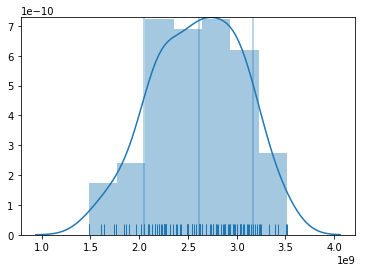

In [43]:
plot_hcip(hcip)

The histogram looks a bit ragged, but this is probably because of the relatively small number of samples.

### Exercise

1. How does the histogram look if you take 1000 samples instead of 100?
1. Make distributions for some of the other properties, like net:gross, thickness and FVF.
1. Maybe our functions should check that we don't get unreasonable values, like negative numbers, or decimal fractions over 1.0 Try to implement this if you have time.

## Using more sophisticated distributions

`scipy` has some distribution functions too. While they're a bit more complicated to use than NumPy's, they are more rigorous. For example, they allow us to fit to data.

Following [this post](https://mikulskibartosz.name/monte-carlo-simulation-in-python-d63f0cfcdf6f)

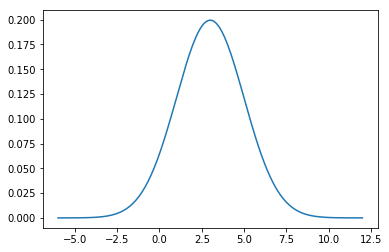

In [44]:
from scipy.stats import norm

normal_distribution = norm(loc=3, scale=2)

x = np.linspace(-6, 12, 200)
pdf = normal_distribution.pdf(x)

plt.plot(x, pdf)
plt.show()

In [45]:
normal_distribution.rvs(trials)

array([ 0.32742367,  4.1970351 ,  1.15757663,  4.67241194,  4.21836754,
        2.06652157,  4.01075953,  0.48899858,  3.21980873,  4.48737317,
        1.51442905,  1.31560359,  3.05767847,  1.70279201,  2.24654248,
        3.21367882,  4.5183195 , -2.05717651, -1.47833114,  1.3118163 ,
       -1.39033532,  3.25303713,  3.8080567 ,  4.01722603,  2.17139061,
        2.49148595,  3.90778375,  4.74841678,  1.38108294,  4.05013959,
        0.83767218,  4.36661303,  4.7875273 ,  0.57868556,  4.45733949,
        3.58971851,  6.57921959,  1.44450457,  1.74937431,  2.73653658,
        1.32950049,  5.49940658,  3.21067233,  2.63164472,  0.10380764,
        3.03468319, -0.29022738,  4.28872213,  1.20937643,  4.033434  ,
        2.98475682,  7.29715008,  5.3757867 , -0.05753365,  1.34333584,
        3.0572442 ,  5.87430422,  1.32317406, -1.38177285, -0.03309972,
        3.42915836,  4.89448132, -1.24860512,  0.7444635 ,  4.53705502,
       -0.91530337,  2.89947402,  5.08622672,  7.01938467,  2.85

Let's fit a log-normal distribution to some porosity data.

In [46]:
df = pd.read_csv("../data/Atkinson_etal_1990_Porosity_data_Alaska_North_Slope.csv", index_col=0)

In [47]:
df.head()

,Porosity,Facies
0,21.0,mid braided
1,21.3,mid braided
2,22.5,mid braided
3,23.7,mid braided
4,25.8,mid braided


In [48]:
df.Facies.unique()

array(['mid braided', 'distal braided', 'distal fluvial'], dtype=object)

In [49]:
filt = df[df.Facies == 'distal fluvial']

In [50]:
from scipy.stats import lognorm

s, loc, scale = lognorm.fit(filt.Porosity/100)

In [51]:
s, loc, scale

(0.0043003457925543005, -7.324267327734386, 7.5404039385185815)

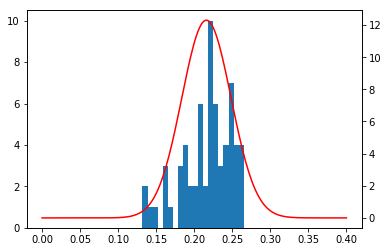

In [52]:
x = np.linspace(0, 0.40, 200)

_, ax = plt.subplots()
plt.hist(filt.Porosity/100, bins=20)
ax2 = ax.twinx()
ax2.plot(x, lognorm.pdf(x, loc=loc, scale=scale, s=s), 'r')
plt.show()

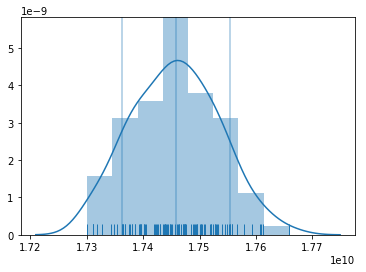

In [53]:
por = lognorm.rvs(s=s, size=trials)

hcip = calculate_hcip(thick, area, height, top, netg, por, s_o, fvf)

plot_hcip(hcip)

## Working on lots of prospects

Let's try reading data from a CSV.

In [54]:
df = pd.read_csv('../data/prospects.csv')

In [55]:
df.head()

,Index,Name,Thick [m],Area [km2],GeomFactor,N:G,phi,So,Bo
0,0,Prospect_1,173,65.714854,0.73,0.26,0.150557,0.45,1.10
1,1,Prospect_2,410,40.684869,0.43,0.59,0.163122,0.38,1.23
2,2,Prospect_3,160,13.883810,0.55,0.16,0.167810,0.59,1.29
3,3,Prospect_4,11,5.572679,0.67,0.12,0.176766,0.29,1.20
4,4,Prospect_5,257,49.995814,0.81,0.31,0.179255,0.14,1.28


In [56]:
def hcip_df(row):
    """
    Wraps calculate_hcip(), mapping the columns of the prospect
    CSV to the required arguments.
    """
    por = norm(loc=row['phi'], scale=0.02).rvs(trials)
    hcip = calculate_hcip(thick=row['Thick [m]']*unit.m,
                          area=row['Area [km2]']*unit.km**2,
                          height=row['Thick [m]'], top='slab',
                          netg=row['N:G'],
                          por=por,
                          s_o=row['So'],
                          fvf=row['Bo'],
                          )
    return np.median(hcip.to('bbl'))

In [57]:
df['HCIP [bbl]'] = df.apply(hcip_df, axis=1)

In [58]:
df.head()

,Index,Name,Thick [m],Area [km2],GeomFactor,N:G,phi,So,Bo,HCIP [bbl]
0,0,Prospect_1,173,65.714854,0.73,0.26,0.150557,0.45,1.10,1.124420e+09
1,1,Prospect_2,410,40.684869,0.43,0.59,0.163122,0.38,1.23,3.166084e+09
2,2,Prospect_3,160,13.883810,0.55,0.16,0.167810,0.59,1.29,1.733716e+08
3,3,Prospect_4,11,5.572679,0.67,0.12,0.176766,0.29,1.20,1.989259e+06
4,4,Prospect_5,257,49.995814,0.81,0.31,0.179255,0.14,1.28,4.926441e+08


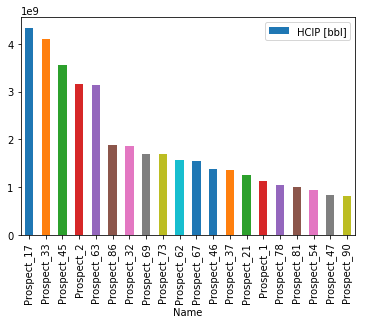

In [59]:
df.nlargest(20, 'HCIP [bbl]').plot.bar(x='Name', y='HCIP [bbl]')

In [60]:
df.to_csv('prospect_volumes.csv')

<hr />

<div>
<img src="https://avatars1.githubusercontent.com/u/1692321?s=50"><p style="text-align:center">© Agile Geoscience 2018</p>
</div>